# **Animals with Attributes Classification using ResNet50 and Token Classification with BERT**

In [4]:
import os
import torch
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from timm import create_model

## **Configure device and hyperparameters**
Here we set the paths, device, and training parameters such as the number of epochs, batch size, and learning rate.

### **Dataset Information**

The dataset used in this project is the **"Animals with Attributes 2" (AwA2)** dataset, which is publicly available at [https://cvml.ista.ac.at/AwA2/](https://cvml.ista.ac.at/AwA2/).

The AwA2 dataset contains images of 50 animal classes along with attribute annotations, making it a popular choice for fine-grained image classification and attribute prediction tasks.


In [2]:
DATASET_DIR = rf'C:\Users\krapa\Downloads\Animals_with_Attributes2\JPEGImages'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_CLASSES = 50
BATCH_SIZE = 32
EPOCHS = 5
LEARNING_RATE = 1e-4

## **Define transforms and load the dataset**
We'll resize the images to 224x224, convert them to tensors, and load them using `ImageFolder`.

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [4]:
dataset = ImageFolder(DATASET_DIR, transform=transform)
class_names = dataset.classes

num_images = len(dataset)
class_names = [i.replace('+', '_') for i in dataset.classes]
num_classes = len(class_names)

print(f"Number of images: {num_images}")
print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")

Number of images: 37322
Number of classes: 50
Class names: ['antelope', 'bat', 'beaver', 'blue_whale', 'bobcat', 'buffalo', 'chihuahua', 'chimpanzee', 'collie', 'cow', 'dalmatian', 'deer', 'dolphin', 'elephant', 'fox', 'german_shepherd', 'giant_panda', 'giraffe', 'gorilla', 'grizzly_bear', 'hamster', 'hippopotamus', 'horse', 'humpback_whale', 'killer_whale', 'leopard', 'lion', 'mole', 'moose', 'mouse', 'otter', 'ox', 'persian_cat', 'pig', 'polar_bear', 'rabbit', 'raccoon', 'rat', 'rhinoceros', 'seal', 'sheep', 'siamese_cat', 'skunk', 'spider_monkey', 'squirrel', 'tiger', 'walrus', 'weasel', 'wolf', 'zebra']


## **Explore class distribution**
We plot a histogram to see how many images belong to each class.

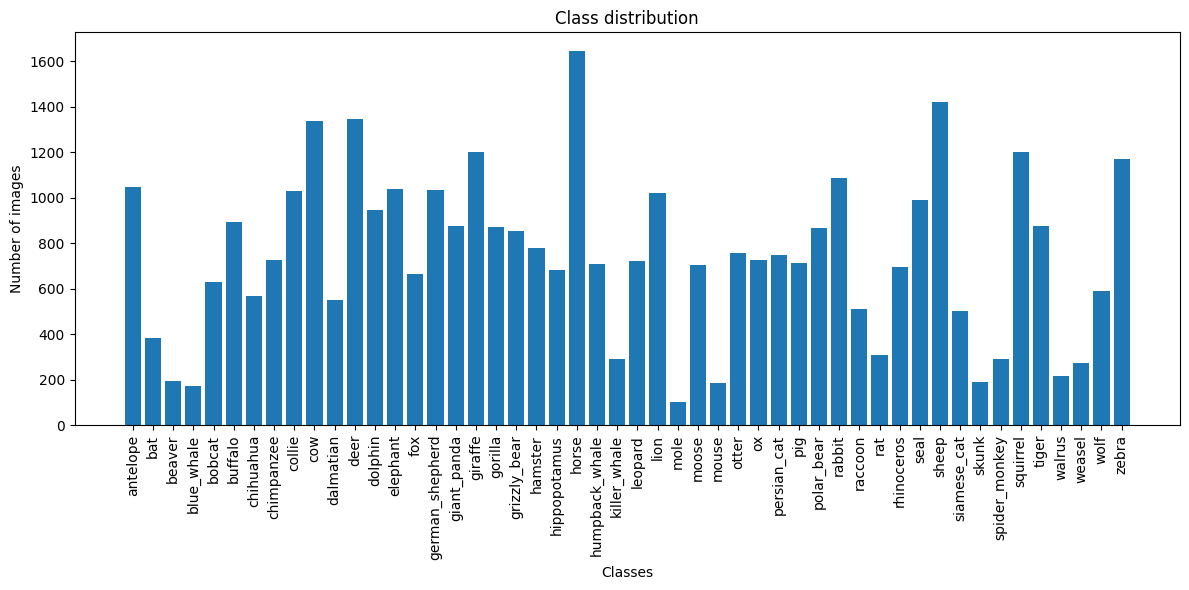

In [6]:
counts = np.bincount(dataset.targets)

plt.figure(figsize=(12, 6))
plt.bar(class_names, counts)
plt.xlabel("Classes")
plt.ylabel("Number of images")
plt.title("Class distribution")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


## **Display sample images**
We randomly select 5 images from the dataset to visualize them along with their labels.

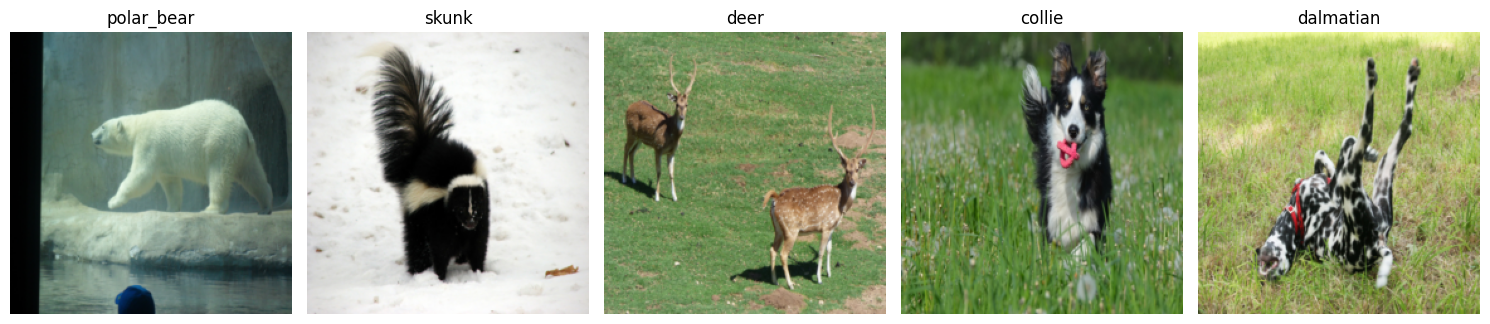

In [7]:
import random

indices = random.sample(range(len(dataset)), 5)

plt.figure(figsize=(15, 5))
for i, idx in enumerate(indices):
    image, label = dataset[idx]
    # (C, H, W) -> (H, W, C)
    image = image.permute(1, 2, 0)
    
    plt.subplot(1, 5, i+1)
    plt.imshow(image)
    plt.title(class_names[label])
    plt.axis('off')
    
plt.tight_layout()
plt.show()


## **Create train, validation, and test splits**
We use stratified splitting to maintain class distribution across splits. First, we split into train and temp (val+test), then split the temp into val and test.


In [9]:
indices = list(range(len(dataset)))
labels = [dataset.targets[i] for i in indices]

In [10]:
# Distribution of data on train and temp (val + test) in stratified mode
train_indices, temp_indices, train_labels, temp_labels = train_test_split(
    indices, labels, test_size=0.1, stratify=labels, random_state=42
)

# Distribution of temp to val and test in stratified mode
val_indices, test_indices, _, _ = train_test_split(
    temp_indices, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

# Create dataset subsets.
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

print(f"Number of images in train: {len(train_dataset)}")
print(f"Number of images in validation: {len(val_dataset)}")
print(f"Number of images in test: {len(test_dataset)}")

Number of images in train: 33589
Number of images in validation: 1866
Number of images in test: 1867


## **Create data loaders**
We'll create `DataLoader` objects for each split to feed batches of images to our model.


In [11]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

print(f'Total number of batches in trainloader : {len(train_loader)}')
print(f'Total number of batches in validloader : {len(val_loader)}')
print(f'Total number of batches in testloader : {len(test_loader)}')

Total number of batches in trainloader : 1050
Total number of batches in validloader : 59
Total number of batches in testloader : 59


## **Model setup - ResNet50**
We load the ResNet50 model pre-trained on ImageNet. Then we freeze all parameters except for the last block (`layer4`). Finally, we replace the fully-connected layer to adapt it to our 50 classes.


In [12]:
# Download ResNet50 with partial freezing of weights
model = models.resnet50(weights="IMAGENET1K_V2")
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last layers
for param in model.layer4.parameters():
    param.requires_grad = True

# New layers for classification
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.45),
    nn.Linear(256, NUM_CLASSES)
)

## **Define optimizer and loss function**
We'll use Adam with a learning rate of `1e-4` and standard cross-entropy loss.


In [15]:
model = model.to(DEVICE)

# Optimizer and loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

## **Define training and evaluation functions**
- **train_fn**: For a single epoch, we iterate over the training set, compute the loss, backpropagate, and update parameters.
- **eval_fn**: For validation (or testing), we only compute the loss and track accuracy without parameter updates.


In [10]:
def train_fn(data_loader, model, optimizer, loss_fn):

    model.train()
    total_loss = 0.0

    for images, labels in tqdm(data_loader):

        images = images.to(DEVICE, non_blocking=True)
        labels = labels.to(DEVICE, non_blocking=True)

        optimizer.zero_grad()
        logits = model(images)
        loss = loss_fn(logits, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.detach().item()
    
    return total_loss / len(data_loader)

def eval_fn(data_loader, model, loss_fn):

    model.eval()
    total_loss = 0.0
    correct = 0

    with torch.no_grad():
        for images, labels in tqdm(data_loader):

            images = images.to(DEVICE, non_blocking=True)
            labels = labels.to(DEVICE, non_blocking=True)

            logits = model(images)
            loss = loss_fn(logits, labels)

            total_loss += loss.item()

            _, preds = torch.max(logits, 1)
            correct += (preds == labels).sum().item()
        
    return total_loss / len(data_loader), correct / len(data_loader.dataset)

## **Training loop**
We train for `EPOCHS` epochs and save the model if it achieves a lower validation loss than previously recorded.


In [11]:
best_valid_loss = np.inf

for i in range(EPOCHS):

    train_loss = train_fn(train_loader, model, optimizer, loss_fn)
    valid_loss, accuracy = eval_fn(val_loader, model, loss_fn)

    if valid_loss < best_valid_loss: 
        torch.save(model.state_dict(), 'best_model.pt')
        print('SAVED-MODEL')
        best_valid_loss = valid_loss
    
    print(f'Epoch : {i+1:02} Train_loss : {train_loss:.3f} Valid_loss: {valid_loss:.3f}, Accuracy: {accuracy:.3f}')

100%|██████████| 59/59 [00:15<00:00,  3.90it/s]


SAVED-MODEL
Epoch : 01 Train_loss : 0.597 Valid_loss: 0.210, Accuracy: 0.941


100%|██████████| 59/59 [00:15<00:00,  3.86it/s]


SAVED-MODEL
Epoch : 02 Train_loss : 0.161 Valid_loss: 0.179, Accuracy: 0.950


100%|██████████| 59/59 [00:15<00:00,  3.74it/s]


Epoch : 03 Train_loss : 0.083 Valid_loss: 0.183, Accuracy: 0.945


100%|██████████| 59/59 [00:15<00:00,  3.85it/s]


Epoch : 04 Train_loss : 0.055 Valid_loss: 0.189, Accuracy: 0.949


100%|██████████| 59/59 [00:15<00:00,  3.77it/s]

Epoch : 05 Train_loss : 0.043 Valid_loss: 0.200, Accuracy: 0.943


## **Visualize predictions on a mini-batch**
We take a small batch from the test set and show the model's predictions vs. true labels.


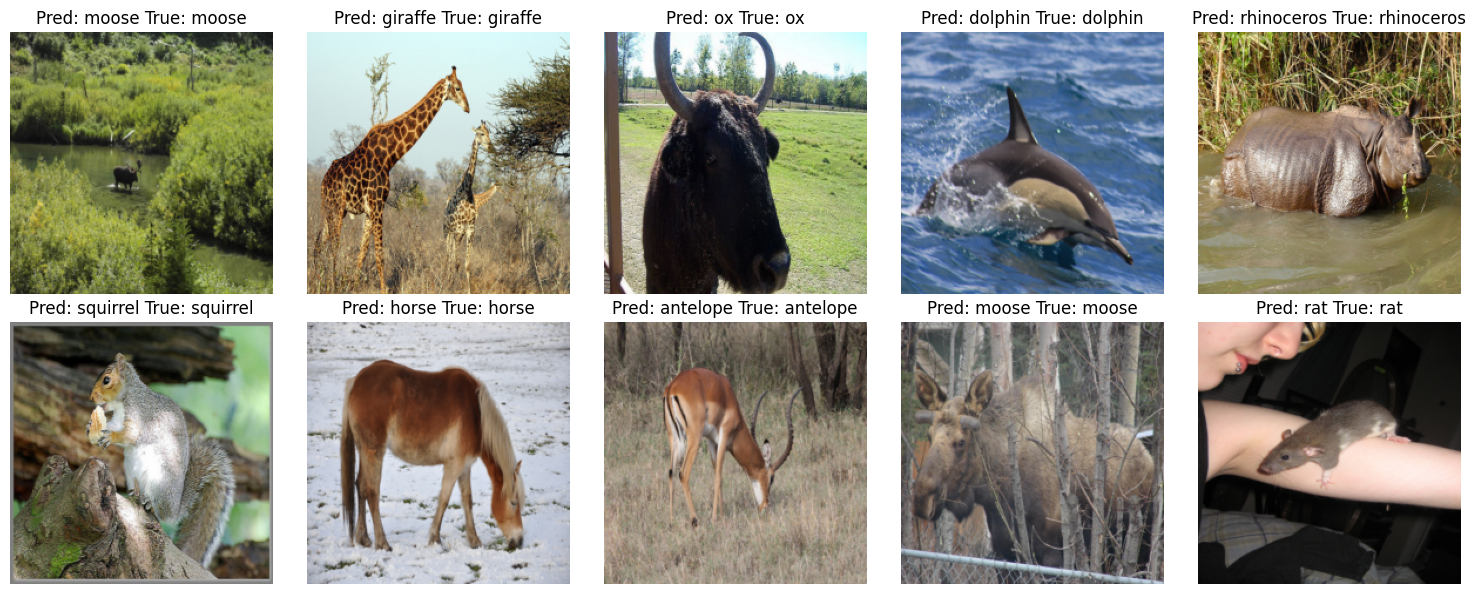

In [17]:
import matplotlib.pyplot as plt


# Test model on 10 images
model.eval()
sample_loader = DataLoader(test_dataset, batch_size=10, shuffle=True)
images, labels = next(iter(sample_loader))
images, labels = images.to(DEVICE), labels.to(DEVICE)
outputs = model(images)
_, preds = torch.max(outputs, 1)

# Visualize results
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()
for img, pred, label, ax in zip(images.cpu(), preds.cpu(), labels.cpu(), axes):
    img = img.permute(1, 2, 0)
    img = img.clamp(0, 1)
    ax.imshow(img)
    ax.set_title(f'Pred: {class_names[pred]} True: {class_names[label]}')
    ax.axis('off')
plt.tight_layout()
plt.show()

## **Single image inference**
Load and transform a single image, run through the model, and display the prediction.


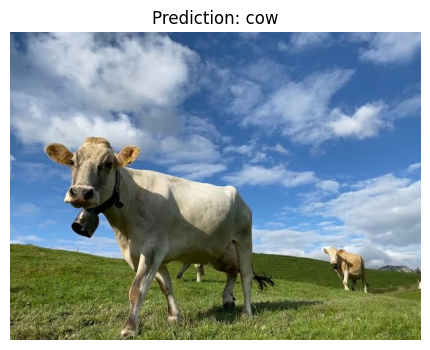

In [18]:
from PIL import Image

image_path = 'cow.jpg'

image = Image.open(image_path).convert('RGB')

input_tensor = transform(image).unsqueeze(0) 
input_tensor = input_tensor.to(DEVICE)

model.eval()

with torch.no_grad():
    output = model(input_tensor)
    _, pred = torch.max(output, 1)

plt.figure(figsize=(6, 4))
plt.imshow(image)
plt.title(f'Prediction: {class_names[pred.item()]}')
plt.axis('off')
plt.show()

# **Named Entity Recognition with BERT**

We now switch gears to a token classification task using a BERT-based model:

### **Dataset Information**

The dataset used for the Named Entity Recognition (NER) task in this project is **"MultiNERD"**, which is publicly available on Hugging Face at [https://huggingface.co/datasets/Babelscape/multinerd](https://huggingface.co/datasets/Babelscape/multinerd).

**MultiNERD** is a multilingual dataset designed for fine-grained and coarse-grained NER tasks, covering a wide range of entity types across different languages.

But the key point here is that there are animal tags in the dataset, and not all languages are needed, only English.


In [1]:
import json
from pathlib import Path

from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import DataCollatorForTokenClassification, Trainer, TrainingArguments
from evaluate import load
seqeval = load("seqeval")

c:\Work\Test_Task\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
label2id = {
    "O": 0,
    "B-PER": 1,
    "I-PER": 2,
    "B-ORG": 3,
    "I-ORG": 4,
    "B-LOC": 5,
    "I-LOC": 6,
    "B-ANIM": 7,
    "I-ANIM": 8,
    "B-BIO": 9,
    "I-BIO": 10,
    "B-CEL": 11,
    "I-CEL": 12,
    "B-DIS": 13,
    "I-DIS": 14,
    "B-EVE": 15,
    "I-EVE": 16,
    "B-FOOD": 17,
    "I-FOOD": 18,
    "B-INST": 19,
    "I-INST": 20,
    "B-MEDIA": 21,
    "I-MEDIA": 22,
    "B-MYTH": 23,
    "I-MYTH": 24,
    "B-PLANT": 25,
    "I-PLANT": 26,
    "B-TIME": 27,
    "I-TIME": 28,
    "B-VEHI": 29,
    "I-VEHI": 30
}
id2label = {v: k for k, v in label2id.items()}
NUM_LABELS = len(label2id)

## **Custom dataset class for JSONL-based NER data**
We read each line, extract tokens and corresponding numeric tags, and align subword tokens with their labels.


In [6]:
class NERJsonlDataset(Dataset):
    def __init__(self, jsonl_path: Path, tokenizer, max_length=128):
        super().__init__()
        self.samples = []
        self.tokenizer = tokenizer
        self.max_length = max_length

        with open(jsonl_path, "r", encoding="utf-8") as f:
            for line in f:
                data = json.loads(line.strip())
                tokens = data["tokens"]
                # 'ner_tags' - list of numbers (0, 0, 5, ...)
                tags = data["ner_tags"]
                self.samples.append((tokens, tags))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        tokens, numeric_tags = self.samples[idx]

        # Tokenization
        encoding = self.tokenizer(
            tokens,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            is_split_into_words=True,
            return_tensors="pt"
        )

        word_ids = encoding.word_ids(batch_index=0)

        # Align labels according to sub-tokens
        aligned_labels = []
        for w_id in word_ids:
            if w_id is None:
                # CLS, SEP, PAD -> -100, to ignore in loss
                aligned_labels.append(-100)
            else:
                # numeric_tags[w_id] is already a number that matches the desired class
                aligned_labels.append(numeric_tags[w_id])

        encoding["labels"] = torch.tensor(aligned_labels, dtype=torch.long)

        # Return dict with tensors
        return {k: v.squeeze() for k, v in encoding.items()}

## **Metric computation with seqeval**
We need to convert predictions and labels back to their string tags before computing precision, recall, f1, and accuracy.


In [7]:
def compute_metrics(p):

    logits, labels = p
    predictions = logits.argmax(axis=-1)

    true_labels = []
    pred_labels = []
    for pred_row, lab_row in zip(predictions, labels):
        tmp_true = []
        tmp_pred = []
        for p_i, l_i in zip(pred_row, lab_row):
            # Ignore special tokens
            if l_i == -100:
                continue
            # Back to the beginning of the first number in the tag: 0 -> "O", 5 -> "B-LOC"
            tmp_true.append(id2label[l_i])
            tmp_pred.append(id2label[p_i])
        true_labels.append(tmp_true)
        pred_labels.append(tmp_pred)

    results = seqeval.compute(predictions=pred_labels, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"]
    }

## **Load the BERT tokenizer and model**
We'll use `bert-base-uncased` as our base model for token classification, adapting it to our labeled NER scheme.


In [ ]:
from transformers import logging
logging.set_verbosity_error()

model_name_or_path = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)

model = AutoModelForTokenClassification.from_pretrained(
    model_name_or_path,
    num_labels=NUM_LABELS,
    id2label=id2label, 
    label2id=label2id
)

C:\Users\krapa\AppData\Local\Temp\ipykernel_15036\1681744512.py:50: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


## **Create the train/val/test datasets**
Update the paths to point to your actual JSONL files.


In [8]:
# Dataset creation
train_dataset = NERJsonlDataset(
    jsonl_path=Path("C:/Work/Test_Task/multinerd/train/train_en.jsonl"),
    tokenizer=tokenizer,
    max_length=128
)
val_dataset = NERJsonlDataset(
    jsonl_path=Path("C:/Work/Test_Task/multinerd/val/val_en.jsonl"),
    tokenizer=tokenizer,
    max_length=128
)
test_dataset = NERJsonlDataset(
    jsonl_path=Path("C:/Work/Test_Task/multinerd/test/test_en.jsonl"),
    tokenizer=tokenizer,
    max_length=128
)

## **Initialize the data collator and training arguments**
The `DataCollatorForTokenClassification` helps handle padding and dynamic sequence lengths for token classification.


In [9]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

# Parameters
training_args = TrainingArguments(
    output_dir="output_ner",
    overwrite_output_dir=True,
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_steps=10,
    learning_rate=5e-5,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True
)

c:\Work\Test_Task\venv\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


## **Setup Trainer and start training**
We use Hugging Face's `Trainer` class to handle the training loop. Metrics are logged and the best model is saved.


In [ ]:
# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

trainer.save_model("trained_ner_model")
tokenizer.save_pretrained("trained_ner_model")

## **Load the fine-tuned model and tokenizer for inference**
We use the saved model to create a pipeline and run predictions on a sample text.


In [11]:
model = AutoModelForTokenClassification.from_pretrained('NER/trained_ner_model')
tokenizer = AutoTokenizer.from_pretrained('NER/trained_ner_model')

from transformers import pipeline

# Create NER-pipeline
ner_pipeline = pipeline(
    "token-classification",
    model=model,
    tokenizer=tokenizer,
    aggregation_strategy='first'
)

# Text example
text = "The strength of the compression of the jaws during the bite and the tiger and lion are about the same."

# Apply pipeline
predictions = ner_pipeline(text)

print(predictions)

extracted_entities = [item["word"] for item in predictions if item['entity_group'] == 'ANIM']
print(extracted_entities)

Device set to use cuda:0


[{'entity_group': 'ANIM', 'score': np.float32(0.85449195), 'word': 'tiger', 'start': 68, 'end': 73}, {'entity_group': 'ANIM', 'score': np.float32(0.86348504), 'word': 'lion', 'start': 78, 'end': 82}]
['tiger', 'lion']


In [12]:
from PIL import Image
from classifier.inference import run_inference
from NER.inference import run_ner

image = Image.open("tiger.jpg").convert('RGB')

entities = run_ner('There is a tiger in picture')
pred = run_inference(image)

print(pred in entities)

True


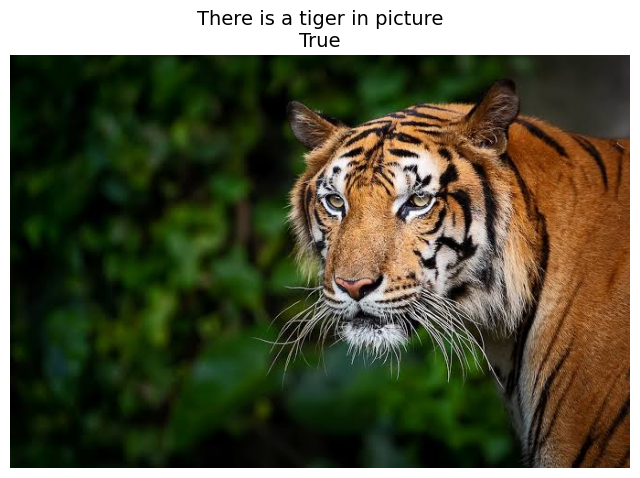

In [18]:
from PIL import Image
from classifier.inference import run_inference
from NER.inference import run_ner
import matplotlib.pyplot as plt

# Завантаження зображення
image = Image.open("tiger.jpg").convert('RGB')
text = 'There is a tiger in picture'

# Запуск NER та класифікації зображення
entities = run_ner(text)
pred = run_inference(image)

# Відображення зображення з текстом і результатом
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis('off')

# Виведення тексту на зображенні
result_text = f'{text}\n{pred in entities}'
plt.title(result_text, fontsize=14)

plt.show()
